In [74]:
%load_ext autoreload
%autoreload 2

from ctapipe.io import event_source
import sys
 
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import sys
from scipy.stats import norm
from traitlets.config.loader import Config 
from ctapipe import utils

# ctapipe modules
from ctapipe.visualization import CameraDisplay
from ctapipe.plotting.camera import CameraPlotter
from ctapipe.image.extractor import *

from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader
from ctapipe.instrument import TelescopeDescription, CameraGeometry

camera=CameraGeometry.from_name("NectarCam", 2)


run=1232 # 22/05
file = '/ctadata/NectarCAM/2019/20190522/NectarCAM.Run{}.0000.fits.fz'.format(run)

reader = event_source(file, max_events=None)
print(f"Read files {reader.file_list}")


channel=['HG','LG']

tel_id=0 # nectaeCAM for the moment


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Read files ['/ctadata/NectarCAM/2019/20190522/NectarCAM.Run1232.0000.fits.fz']


In [61]:
for i, event in enumerate(reader): 
    
    # select only flatfield events    
    if event.r1.tel[0].trigger_type == 32:        
        continue
    elif event.r1.tel[0].trigger_type == 4 or  event.r1.tel[0].trigger_type == 5:        
        break
        
print(f"read event id: {event.r0.event_id}, trigger {event.r0.tel[0].trigger_type}")
       

read event id: 2, trigger 4


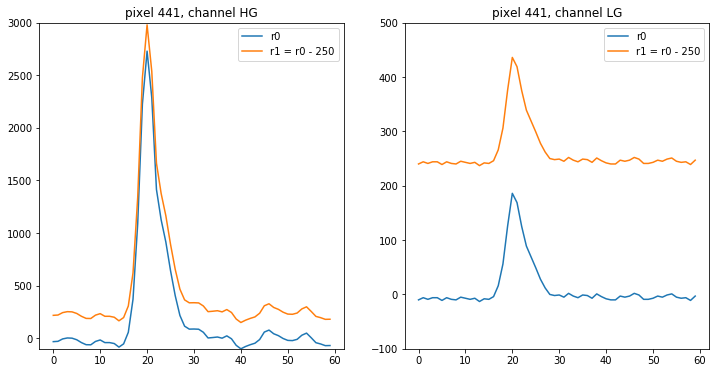

In [82]:
pix=441


fig = plt.figure(300,figsize=(12, 6))
label="r0"
label1="r1 = r0 - 250"
chan=0
plt.subplot(1, 2, 1)
plt.plot(event.r1.tel[0].waveform[chan,pix], label=label) 
plt.plot(event.r0.tel[0].waveform[chan,pix], label=label1)   
plt.title(f"pixel {pix}, channel {channel[chan]}")
plt.ylim(-100,3000)
plt.legend()
chan=1
plt.subplot(1, 2, 2)
plt.ylim(-100,500)
plt.plot(event.r1.tel[0].waveform[chan,pix], label=label)
plt.plot(event.r0.tel[0].waveform[chan,pix], label=label1)
plt.title(f"pixel {pix}, channel {channel[chan]}")
plt.legend()
#plt.savefig(f"flatfield_outliers_pixel{pix}_event_{event.r0.event_id}_run{run}.png")

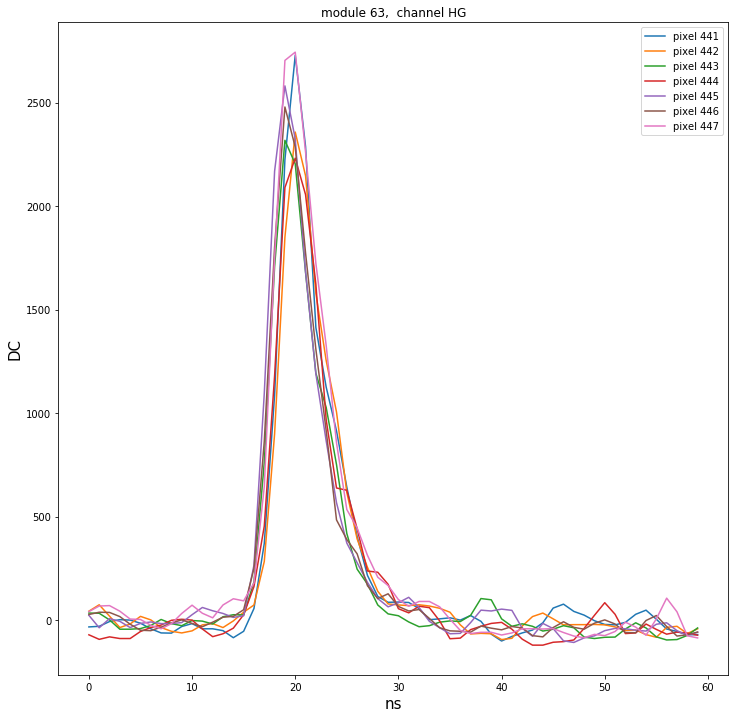

In [90]:
# plot R1 waveform of module [module]
def view_waveform(chan=0, pix_id=6,i=0):
    waveform = event.r1.tel[tel_id].waveform
    plt.plot(waveform[chan, pix_id], label=f'pixel {pix_id}')
  
    plt.title(f"module {module_id},  channel {channel[chan]}",)
    max_now=waveform[chan, pix_id].max()
    min_now=waveform[chan, pix_id].min()


    plt.legend()
    plt.ylabel('DC',fontsize=15) 
    plt.xlabel('ns',fontsize=15)
    

# module number    

module=63
module_rank=np.where(event.nectarcam.tel[0].svc.module_ids==module)

# ids of pixel in module
pixels_mod=event.nectarcam.tel[0].svc.pixel_ids[module_rank[0][0]*7:module_rank[0][0]*7+7]
 
# channel
chan=0
 
fig = plt.figure(num=0,figsize=(12,12))     

for i,pix  in enumerate(pixels_mod):    

    view_waveform(chan=chan, pix_id=pix,i=i)
    
#plt.savefig(f"Run{run}_waveform_channel_{channel[chan]}_module_{module_id}.png")    

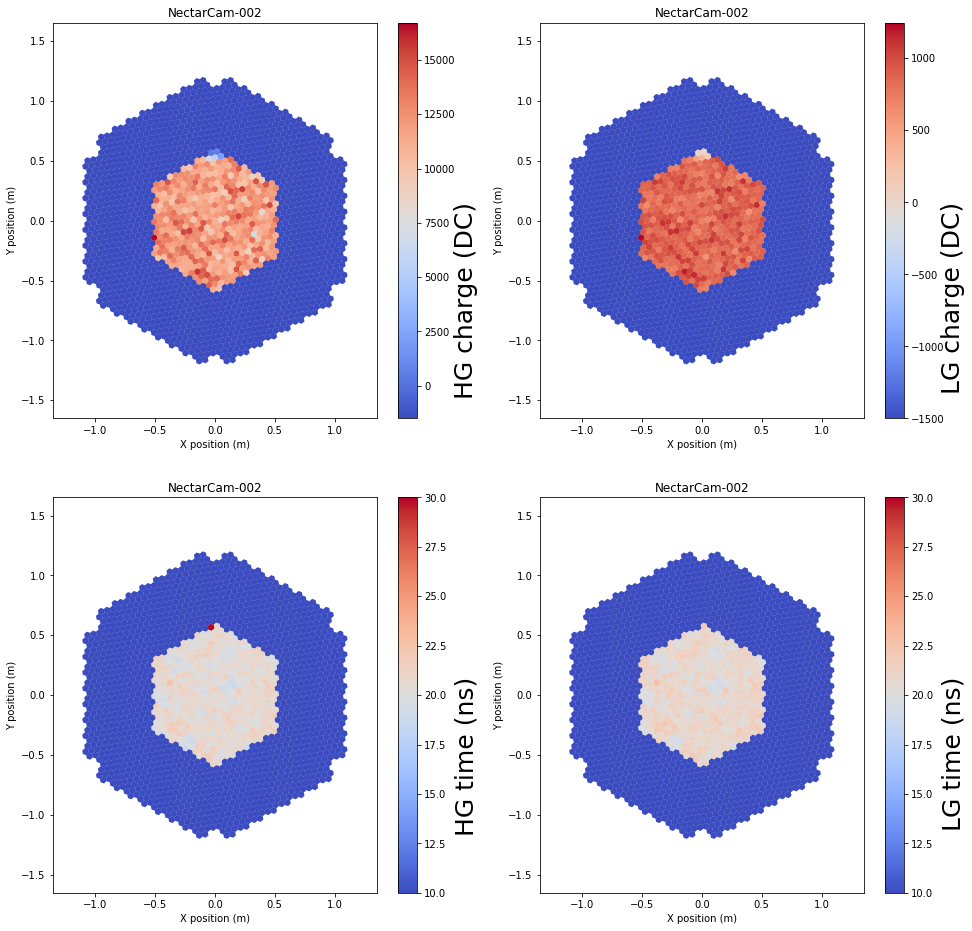

In [91]:
# integrate the charge on 12 ns around the peak value

config = Config({
    "LocalPeakWindowSum": {
        "window_shift": 4,
        "window_width": 10 
    }
})
integrator = LocalPeakWindowSum(config=config)


waveform=event.r1.tel[0].waveform
image, peakpos = integrator(waveform)


fig = plt.figure(figsize=(16, 16))
for chan in(np.arange(2)):
    ax = plt.subplot(2, 2, chan+1)

    disp = CameraDisplay(event.inst.subarray.tels[0].camera)
    disp.image = image[chan]  
    
    #disp.set_limits_minmax(2000,4000)
    disp.cmap = plt.cm.coolwarm
    disp.axes.text(2.0, 0, f'{channel[chan]} charge (DC)', fontsize=25,rotation=90)
    disp.add_colorbar()
   
    ax = plt.subplot(2, 2, chan+3)
    disp = CameraDisplay(event.inst.subarray.tels[0].camera)
    disp.image = peakpos[chan]  
    disp.cmap = plt.cm.coolwarm
    disp.set_limits_minmax(10,30)
    disp.axes.text(2.0, 0, f'{channel[chan]} time (ns)', fontsize=25, rotation=90)
    
    disp.add_colorbar()

    disp.update()

#plt.savefig(f"Run{run}_event_{event.nectarcam.tel[0].evt.event_id}_charge_time.png")   

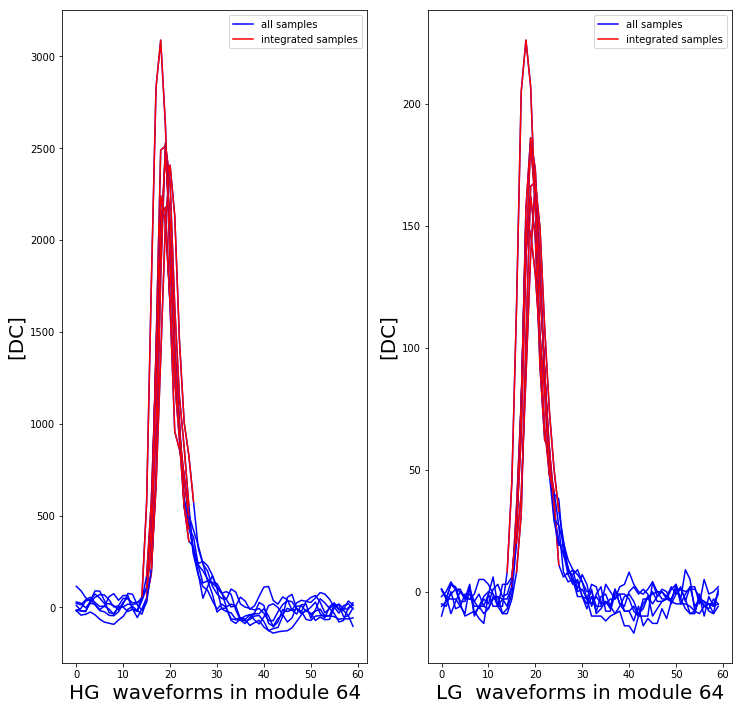

In [75]:
# Plot the part of the waveform that is integrated
# (this work only after the line above)

fig = plt.figure(0,figsize=(12,12))

# consider only 36 samples
samples=np.arange(0,60)

# chose the module
mod = 1
module_id=event.nectarcam.tel[0].svc.module_ids[mod]
# find pixel index in module
pix_in_mod = event.nectarcam.tel[0].svc.pixel_ids[mod*7:mod*7+7]

for chan in(np.arange(2)): 

    plt.subplot(1,2,chan+1)
    
    for i,pix in enumerate(pix_in_mod):
    
        # samples used to calculate the charge
        start=int(max(peakpos[chan,pix]-integrator.window_shift,0))
        stop=int(min(start+integrator.window_width,60))
        used_samples=np.arange(start,stop)
        used=waveform[chan,pix,start:stop]
        
            
        plt.plot(waveform[chan,pix,], color='b', label='all samples')
        plt.plot(used_samples,used, color='r', label='integrated samples')
        
        if i==0:
            plt.legend()
           
        #plt.ylim(-150,300)    
        plt.ylabel("[DC]",fontsize=20)
        plt.xlabel(f"{channel[chan]}  waveforms in module {module_id}",fontsize=20)
        #plt.ylim(-50,4000)
        #plt.legend()
        fig.savefig(f"Run{run}_waverforms_module_zoom_{module_id}.png")
        
        #fig.savefig(f"Run{run}_event_75_all.png")


In [79]:
# use the tool to write calibration coefficients
# you can call it also as "python write_camera_calibration.py --help"

from nectarchain.tools.write_camera_calibration import CalibrationHDF5Writer
calibration_tool= CalibrationHDF5Writer()
calibration_tool.print_help()

Generate a HDF5 file with camera calibration coefficients

Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--input_file=<Unicode> (EventSource.input_url)
    Default: ''
    Path to the input file containing events.
--max_events=<Int> (EventSource.max_events)
    Default: None
    Maximum number of events that will be read from the file
--flatfield_product=<CaselessStrEnum> (CalibrationHDF5Writer.flatfield_product)
    Default: 'FlasherFlatFieldCalculator'
    Choices: ['FlasherFlatFieldCalculator']
    FlatFieldCalculator to use.
--pedestal_product=<CaselessStrEnum> (CalibrationHDF5Writer.pedestal_product)
    Default: 'PedestalIntegrator'
    Choices: ['PedestalIntegrator']
    PedestalCalculator to use.
--log-level=<Enum> (Application.log_level)
    Default: 30
    Choices: (0, 10, 20, 30, 40, 50, 'DEBUG', 'INFO', 'WARN', 'ERRO

In [80]:
# 
calibration_tool.run(argv=['--config','../nectarchain/tools/write_camera_calibration_param.json'])

INFO [CalibrationHDF5Writer] (tool/initialize): ctapipe version 0.6.2.post183+gitc5fe5fe
INFO [CalibrationHDF5Writer] (tool/run): Starting: CalibrationHDF5Writer
INFO [CalibrationHDF5Writer.FlasherFlatFieldCalculator] (flatfield/__init__): extractor <ctapipe.image.extractor.LocalPeakWindowSum object at 0x7f1c13373828>
INFO [CalibrationHDF5Writer.FlasherFlatFieldCalculator] (flatfield/__init__): Used events statistics : 100
INFO [CalibrationHDF5Writer.PedestalIntegrator] (pedestals/__init__): extractor <ctapipe.image.extractor.FixedWindowSum object at 0x7f1c12967390>
INFO [CalibrationHDF5Writer.PedestalIntegrator] (pedestals/__init__): Used events statistics : 20
INFO [CalibrationHDF5Writer] (tool/run): CONFIG: {'CalibrationHDF5Writer': {'config_file': '../nectarchain/tools/write_camera_calibration_param.json', 'flatfield_product': 'FlasherFlatFieldCalculator', 'log_datefmt': '%Y-%m-%d %H:%M:%S', 'log_format': '%(levelname)s [%(name)s] (%(module)s/%(funcName)s): %(message)s', 'log_level

Table '/tel_0/flatfield' is missing column 'charge_std_outliers' that is in container FlatFieldContainer. It will be skipped.


{'sample_time': <Quantity 0. s>, 'sample_time_range': <Quantity [0., 0.] s>, 'n_events': 100, 'charge_mean': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'charge_median': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'charge_std': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'time_mean': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'time_median': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'time_std': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'relative_gain_mean': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'relative_gain_median': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'relative_gain_std': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'relative_time_median': array([[0., 0., 0., ..., 0.

Text(0.5,1,'ADC per photon-electrons, mean=   68 ADC')

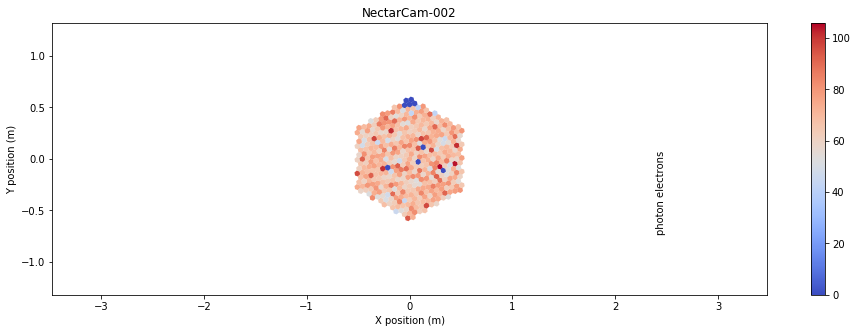

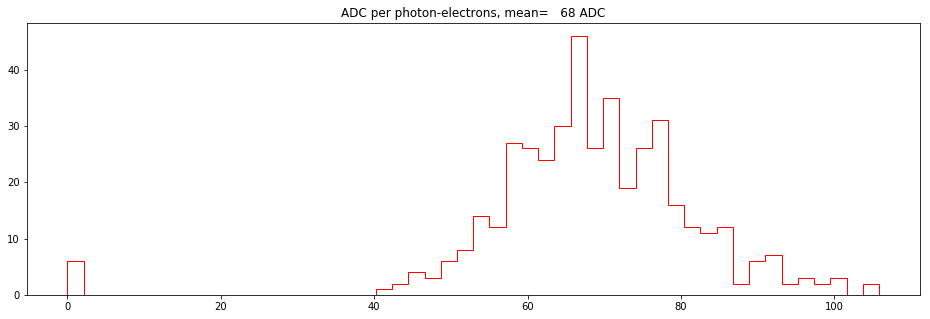

In [81]:
# read back the monitoring containers written with the tool write_camera_calibration.py
from ctapipe.io.containers import FlatFieldContainer, WaveformCalibrationContainer
from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader
ff_data = FlatFieldContainer()
cal_data =  WaveformCalibrationContainer()

with HDF5TableReader('calibration.hdf5') as h5_table:

    assert h5_table._h5file.isopen == True


    for cont in h5_table.read('/tel_0/flatfield', ff_data):
            print(cont.as_dict())
            
    for cont in h5_table.read('/tel_0/calibration', cal_data):
            print(cont.as_dict())
          
            break
                    
h5_table.close() 

chan=0
values=1/cont.dc_to_pe[chan]
# Perform some plots
fig = plt.figure(13,figsize=(16, 5))
disp = CameraDisplay(camera)                                                                             
disp.image = values
#disp.set_limits_minmax(0,1)
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, 'photon electrons', rotation=90)
disp.add_colorbar()

# 
select=np.logical_not(cont.unusable_pixels[0])


fig = plt.figure(12,figsize=(16, 5))
plt.hist(values[select], color='r', histtype='step', bins = 50, stacked=True, fill=False)
plt.title(f"ADC per photon-electrons, mean={np.mean(values[select]):5.0f} ADC") 
